<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Meta-Learning_Projects/blob/main/Prototypical_Net/ProtoNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob

import google_drive_downloader as gdd
import imageio
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import dataset, sampler, dataloader
from torch import nn
import torch.nn.functional as F
from torch import autograd
import matplotlib.pyplot as plt
from torch.utils import tensorboard
#import pdb

NUM_TRAIN_CLASSES = 1100
NUM_VAL_CLASSES = 100
NUM_TEST_CLASSES = 423
NUM_SAMPLES_PER_CLASS = 20

NUM_INPUT_CHANNELS = 1
NUM_HIDDEN_CHANNELS = 64
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SUMMARY_INTERVAL = 10
SAVE_INTERVAL = 100
PRINT_INTERVAL = 10
VAL_INTERVAL = PRINT_INTERVAL * 5
NUM_TEST_TASKS = 600


In [3]:
BASE_PATH = './omniglot_resized'
GDD_FILE_ID = '1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI'
gdd.GoogleDriveDownloader.download_file_from_google_drive(
                file_id=GDD_FILE_ID,
                dest_path=f'{BASE_PATH}.zip',
                unzip=True
            )

Unzipping...Done.


In [4]:
def load_image(file_path):
    """Loads and transforms an Omniglot image.
    Args:
        file_path (str): file path of image
    Returns:
        a Tensor containing image data
            shape (1, 28, 28)
    """
    x = imageio.imread(file_path)
    x = torch.tensor(x, dtype=torch.float32).reshape([1, 28, 28])
    x = x / 255.0
    return 1 - x

In [5]:
class OmniglotDataset(dataset.Dataset):
    """Omniglot dataset for meta-learning.

    Each element of the dataset is a task. A task is specified with a key,
    which is a tuple of class indices (no particular order). The corresponding
    value is the instantiated task, which consists of sampled (image, label)
    pairs.
    """

    def __init__(self, num_support, num_query):
        """Inits OmniglotDataset.

        Args:
            num_support (int): number of support examples per class
            num_query (int): number of query examples per class
        """
        super().__init__()

        # get all character folders
        self._character_folders = glob.glob(
            os.path.join(BASE_PATH, '*/*/'))
        assert len(self._character_folders) == (
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )

        # shuffle characters
        np.random.default_rng(0).shuffle(self._character_folders)

        # check problem arguments
        assert num_support + num_query <= NUM_SAMPLES_PER_CLASS
        self._num_support = num_support
        self._num_query = num_query

    def __getitem__(self, class_idxs):
        """Constructs a task.

        Data for each class is sampled uniformly at random without replacement.
        The ordering of the labels corresponds to that of class_idxs.

        Args:
            class_idxs (tuple[int]): class indices that comprise the task

        Returns:
            images_support (Tensor): task support images
                shape (num_way * num_support, channels, height, width)
            labels_support (Tensor): task support labels
                shape (num_way * num_support,)
            images_query (Tensor): task query images
                shape (num_way * num_query, channels, height, width)
            labels_query (Tensor): task query labels
                shape (num_way * num_query,)
        """
        images_support, images_query = [], []
        labels_support, labels_query = [], []

        for label, class_idx in enumerate(class_idxs):
            # get a class's examples and sample from them
            all_file_paths = glob.glob(
                os.path.join(self._character_folders[class_idx], '*.png')
            )
            sampled_file_paths = np.random.default_rng().choice(
                all_file_paths,
                size=self._num_support + self._num_query,
                replace=False
            )
            images = [load_image(file_path) for file_path in sampled_file_paths]

            # split sampled examples into support and query
            images_support.extend(images[:self._num_support])
            images_query.extend(images[self._num_support:])
            labels_support.extend([label] * self._num_support)
            labels_query.extend([label] * self._num_query)

        # aggregate into tensors
        images_support = torch.stack(images_support)  # shape (N*S, C, H, W)
        labels_support = torch.tensor(labels_support)  # shape (N*S)
        images_query = torch.stack(images_query)
        labels_query = torch.tensor(labels_query)

        return images_support, labels_support, images_query, labels_query


In [6]:
class OmniglotSampler(sampler.Sampler):
    """Samples task specification keys for an OmniglotDataset."""

    def __init__(self, split_idxs, num_way, num_tasks):

      """Inits OmniglotSampler.

      Args:
          split_idxs (range): indices that comprise the
              training/validation/test split
          num_way (int): number of classes per task
          num_tasks (int): number of tasks to sample
      """
      super().__init__(None)

      self.split_idxs = split_idxs
      self.num_way = num_way
      self.num_tasks = num_tasks

    def __iter__(self):
      return (
          np.random.default_rng().choice(
              self.split_idxs,
              size=self.num_way,
              replace=False
          ) for _ in range(self.num_tasks)
      )

    def __len__(self):
        return self.num_tasks

In [7]:
def identity(x):
    return x

def get_omniglot_dataloader(
        split,
        batch_size,
        num_way,
        num_support,
        num_query,
        num_tasks_per_epoch
):
    """Returns a dataloader.DataLoader for Omniglot.

    Args:
        split (str): one of 'train', 'val', 'test'
        batch_size (int): number of tasks per batch
        num_way (int): number of classes per task
        num_support (int): number of support examples per class
        num_query (int): number of query examples per class
        num_tasks_per_epoch (int): number of tasks before DataLoader is
            exhausted
    """

    if split == 'train':
        split_idxs = range(NUM_TRAIN_CLASSES)
    elif split == 'val':
        split_idxs = range(
            NUM_TRAIN_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES
        )
    elif split == 'test':
        split_idxs = range(
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )
    else:
        raise ValueError

    return dataloader.DataLoader(
        dataset=OmniglotDataset(num_support, num_query),
        batch_size=batch_size,
        sampler=OmniglotSampler(split_idxs, num_way, num_tasks_per_epoch),
        num_workers=2,
        collate_fn=identity,
        pin_memory=torch.cuda.is_available(),
        drop_last=True
    )

In [8]:
image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")
image.shape

<ipython-input-8-913cf8e1afe4>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")


(28, 28)

In [9]:
samples = get_omniglot_dataloader(
        split='train',
        batch_size=1,
        num_way=4,
        num_support=1,
        num_query=1,
        num_tasks_per_epoch=1
)
tasks = next(iter(samples))
for task in tasks:
  images_support, labels_support, images_query, labels_query = task
images_support.shape, labels_support.shape, images_query.shape, labels_query.shape

<ipython-input-4-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


(torch.Size([4, 1, 28, 28]),
 torch.Size([4]),
 torch.Size([4, 1, 28, 28]),
 torch.Size([4]))

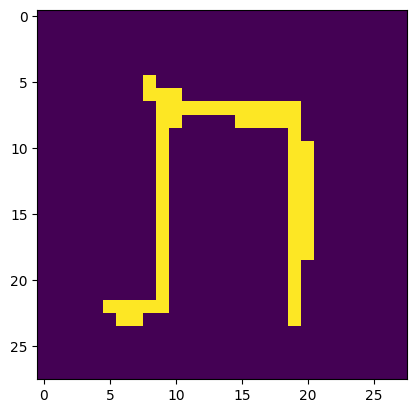

In [10]:
plt.imshow(images_support[0][0])

In [11]:
labels_support

tensor([0, 1, 2, 3])

In [17]:
def score(logits, labels):
    """Returns the mean accuracy of a model's predictions on a set of examples.

    Args:
        logits (torch.Tensor): model predicted logits
            shape (examples, classes)
        labels (torch.Tensor): classification labels from 0 to num_classes - 1
            shape (examples,)
    """


    assert logits.dim() == 2
    assert labels.dim() == 1
    assert logits.shape[0] == labels.shape[0]
    y = torch.argmax(logits, dim=-1) == labels
    y = y.type(torch.float)
    return torch.mean(y).item()

In [18]:
class ProtoNetNetwork(nn.Module):
    """Container for ProtoNet weights and image-to-latent computation."""

    def __init__(self):
        """Inits ProtoNetNetwork.

        The network consists of four convolutional blocks, each comprising a
        convolution layer, a batch normalization layer, ReLU activation, and 2x2
        max pooling for downsampling. There is an additional flattening
        operation at the end.

        Note that unlike conventional use, batch normalization is always done
        with batch statistics, regardless of whether we are training or
        evaluating. This technically makes meta-learning transductive, as
        opposed to inductive.
        """
        super().__init__()
        layers = []
        in_channels = NUM_INPUT_CHANNELS
        for _ in range(NUM_CONV_LAYERS):
            layers.append(
                nn.Conv2d(
                    in_channels,
                    NUM_HIDDEN_CHANNELS,
                    (KERNEL_SIZE, KERNEL_SIZE),
                    padding='same'
                )
            )
            layers.append(nn.BatchNorm2d(NUM_HIDDEN_CHANNELS))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = NUM_HIDDEN_CHANNELS
        layers.append(nn.Flatten())
        self._layers = nn.Sequential(*layers)
        self.to(DEVICE)

    def forward(self, images):
        """Computes the latent representation of a batch of images.

        Args:
            images (Tensor): batch of Omniglot images
                shape (num_images, channels, height, width)

        Returns:
            a Tensor containing a batch of latent representations
                shape (num_images, latents)
        """
        return self._layers(images)


In [19]:
class ProtoNet:
    """Trains and assesses a prototypical network."""

    def __init__(self, learning_rate, log_dir):
        """Inits ProtoNet.

        Args:
            learning_rate (float): learning rate for the Adam optimizer
            log_dir (str): path to logging directory
        """

        self._network = ProtoNetNetwork()
        self._optimizer = torch.optim.Adam(
            self._network.parameters(),
            lr=learning_rate
        )
        self._log_dir = log_dir
        os.makedirs(self._log_dir, exist_ok=True)

        self._start_train_step = 0

    def _step(self, task_batch):
        """Computes ProtoNet mean loss (and accuracy) on a batch of tasks.

        Args:
            task_batch (tuple[Tensor, Tensor, Tensor, Tensor]):
                batch of tasks from an Omniglot DataLoader

        Returns:
            a Tensor containing mean ProtoNet loss over the batch
                shape ()
            mean support set accuracy over the batch as a float
            mean query set accuracy over the batch as a float
        """

        loss_batch = []
        accuracy_support_batch = []
        accuracy_query_batch = []
        for task in task_batch:
            images_support, labels_support, images_query, labels_query = task
            images_support = images_support.to(DEVICE)
            labels_support = labels_support.to(DEVICE)
            images_query = images_query.to(DEVICE)
            labels_query = labels_query.to(DEVICE)
            # For a given task, compute the prototypes and the protonet loss.
            # F.cross_entropy to compute classification losses.
            # score to compute accuracies.
            # Populate loss_batch, accuracy_support_batch, and
            # accuracy_query_batch.

            # we need to compute all of the prototypes for all classes in the task training batch
            supp_feats = self._network(images_support)

            # get all classes, and then score
            classes = torch.unique(labels_support, sorted=True)
            means = []
            for c in classes:
                idxes = (labels_support == c).nonzero()
                class_feats = supp_feats[idxes]
                prototype = torch.mean(class_feats, dim=0)
                means.append(prototype)

            means = torch.cat(means)  # (num_classes, feature_dim)

            # now to measure distances to all means
            # (batch_size, feature_dim)
            query_feats = self._network(images_query)
            # (batch_size, num_classes, feature_dim)
            query_feats = torch.stack([query_feats] * means.size(0), dim=1)

            exp_means = means.expand(*query_feats.shape)

            # (batch_size, num_classes, feature_dim)
            query_diffs = query_feats - exp_means
            # (batch_size, num_classes)
            query_sq_norms = torch.norm(query_diffs, p=2, dim=-1).square()
            query_logits = -query_sq_norms
            # query_norms[i][j] = d(f_\theta(x_i), c_j)

            loss = F.cross_entropy(query_logits, labels_query)
            loss_batch.append(loss)

            # compute accuracies
            query_acc =  score(query_logits, labels_query)
            accuracy_query_batch.append(query_acc)

            # (batch_size, num_classes, feature_dim)
            supp_feats = torch.stack([supp_feats] * means.size(0), dim=1)

            exp_means = means.expand(*supp_feats.shape)

            # (batch_size, num_classes, feature_dim)
            supp_diffs = supp_feats - exp_means
            # (batch_size, num_classes)
            supp_sq_norms = torch.norm(supp_diffs, p=2, dim=2).square()
            supp_logits = -supp_sq_norms
            supp_acc =  score(supp_logits, labels_support)
            accuracy_support_batch.append(supp_acc)


        return (
            torch.mean(torch.stack(loss_batch)),
            np.mean(accuracy_support_batch),
            np.mean(accuracy_query_batch)
        )

    def train(self, dataloader_train, dataloader_val, writer):
        """Train the ProtoNet.

        Consumes dataloader_train to optimize weights of ProtoNetNetwork
        while periodically validating on dataloader_val, logging metrics, and
        saving checkpoints.

        Args:
            dataloader_train (DataLoader): loader for train tasks
            dataloader_val (DataLoader): loader for validation tasks
            writer (SummaryWriter): TensorBoard logger
        """
        print(f'Starting training at iteration {self._start_train_step}.')
        for i_step, task_batch in enumerate(
                dataloader_train,
                start=self._start_train_step
        ):
            self._optimizer.zero_grad()
            loss, accuracy_support, accuracy_query = self._step(task_batch)
            loss.backward()
            self._optimizer.step()

            if i_step % PRINT_INTERVAL == 0:
                print(
                    f'Iteration {i_step}: '
                    f'loss: {loss.item():.3f}, '
                    f'support accuracy: {accuracy_support.item():.3f}, '
                    f'query accuracy: {accuracy_query.item():.3f}'
                )
                writer.add_scalar('loss/train', loss.item(), i_step)
                writer.add_scalar(
                    'train_accuracy/support',
                    accuracy_support.item(),
                    i_step
                )
                writer.add_scalar(
                    'train_accuracy/query',
                    accuracy_query.item(),
                    i_step
                )

            if i_step % VAL_INTERVAL == 0:
                with torch.no_grad():
                    losses, accuracies_support, accuracies_query = [], [], []
                    for val_task_batch in dataloader_val:
                        loss, accuracy_support, accuracy_query = (
                            self._step(val_task_batch)
                        )
                        losses.append(loss.item())
                        accuracies_support.append(accuracy_support)
                        accuracies_query.append(accuracy_query)
                    loss = np.mean(losses)
                    accuracy_support = np.mean(accuracies_support)
                    accuracy_query = np.mean(accuracies_query)
                print(
                    f'Validation: '
                    f'loss: {loss:.3f}, '
                    f'support accuracy: {accuracy_support:.3f}, '
                    f'query accuracy: {accuracy_query:.3f}'
                )
                writer.add_scalar('loss/val', loss, i_step)
                writer.add_scalar(
                    'val_accuracy/support',
                    accuracy_support,
                    i_step
                )
                writer.add_scalar(
                    'val_accuracy/query',
                    accuracy_query,
                    i_step
                )

            if i_step % SAVE_INTERVAL == 0:
                self._save(i_step)

    def test(self, dataloader_test):
        """Evaluate the ProtoNet on test tasks.

        Args:
            dataloader_test (DataLoader): loader for test tasks
        """
        accuracies = []
        for task_batch in dataloader_test:
            accuracies.append(self._step(task_batch)[2])
        mean = np.mean(accuracies)
        std = np.std(accuracies)
        mean_95_confidence_interval = 1.96 * std / np.sqrt(NUM_TEST_TASKS)
        print(
            f'Accuracy over {NUM_TEST_TASKS} test tasks: '
            f'mean {mean:.3f}, '
            f'95% confidence interval {mean_95_confidence_interval:.3f}'
        )

    def load(self, checkpoint_step):
        """Loads a checkpoint.

        Args:
            checkpoint_step (int): iteration of checkpoint to load

        Raises:
            ValueError: if checkpoint for checkpoint_step is not found
        """
        target_path = (
            f'{os.path.join(self._log_dir, "state")}'
            f'{checkpoint_step}.pt'
        )
        if os.path.isfile(target_path):
            state = torch.load(target_path)
            self._network.load_state_dict(state['network_state_dict'])
            self._optimizer.load_state_dict(state['optimizer_state_dict'])
            self._start_train_step = checkpoint_step + 1
            print(f'Loaded checkpoint iteration {checkpoint_step}.')
        else:
            raise ValueError(
                f'No checkpoint for iteration {checkpoint_step} found.'
            )

    def _save(self, checkpoint_step):
        """Saves network and optimizer state_dicts as a checkpoint.

        Args:
            checkpoint_step (int): iteration to label checkpoint with
        """
        torch.save(
            dict(network_state_dict=self._network.state_dict(),
                 optimizer_state_dict=self._optimizer.state_dict()),
            f'{os.path.join(self._log_dir, "state")}{checkpoint_step}.pt'
        )
        print('Saved checkpoint.')


In [24]:
def main():
    log_dir = None
    num_way = 5
    num_support = 1
    num_query = 5
    learning_rate = 0.001
    batch_size = 5
    num_train_iterations = 10000
    test = False
    checkpoint_step = -1

    if log_dir is None:
        log_dir = f'./logs/protonet/omniglot.way:{ num_way}.support:{ num_support}.query:{ num_query}.lr:{ learning_rate}.batch_size:{ batch_size}'
    print(f'log_dir: {log_dir}')
    writer = tensorboard.SummaryWriter(log_dir=log_dir)

    protonet = ProtoNet( learning_rate, log_dir)

    if  checkpoint_step > -1:
        protonet.load( checkpoint_step)
    else:
        print('Checkpoint loading skipped.')

    if not  test:
        num_training_tasks =  batch_size * ( num_train_iterations -
                                                 checkpoint_step - 1)
        print(
            f'Training on tasks with composition '
            f'num_way={ num_way}, '
            f'num_support={ num_support}, '
            f'num_query={ num_query}'
        )
        dataloader_train = get_omniglot_dataloader(
            'train',
            batch_size,
            num_way,
            num_support,
            num_query,
            num_training_tasks
        )
        dataloader_val = get_omniglot_dataloader(
            'val',
            batch_size,
            num_way,
            num_support,
            num_query,
            batch_size * 4
        )
        protonet.train(
            dataloader_train,
            dataloader_val,
            writer
        )
    else:
        print(
            f'Testing on tasks with composition '
            f'num_way={ num_way}, '
            f'num_support={num_support}, '
            f'num_query={num_query}'
        )
        dataloader_test = get_omniglot_dataloader(
            'test',
            1,
            num_way,
            num_support,
            num_query,
            NUM_TEST_TASKS
        )
        protonet.test(dataloader_test)

In [ ]:
main()